# Benchmark for Community detection

In [1]:
"""Load/import helper functions"""

import time
import random
from LocalPopular import locally_popular_clustering_with_hop_distance, extract_labels_from_communities, time_tester, calculate_scores_CD

from GraphFunctions import generate_agents, calculate_euclidian_relationships, create_graph, \
    my_make_circles, create_graphs_euclid, create_graphs_kNN, \
    generate_graph,create_graphs_hop_distance, create_graphs_hop_distance_abs,randomize_graph_node_labels

from PlotHelperFunctions import plot_clustering, plot_stuff

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import rand_score
import numpy as np
import networkx as nx
from scipy.spatial import distance

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity


import data.jazz as jazz
import data.cora as cora

## Create Graphs

In [2]:
repetitions = 1    #Number of random isomorph permutation for each graph

cora_graph = cora.get_graph()

cora_graph = nx.relabel_nodes(cora_graph, {list(cora_graph.nodes())[i] : i for i in range(len(cora_graph.nodes()))} )
cora_truth = list(cora_graph.nodes[i]['subject'] for i in range(len(cora_graph.nodes())))
cora_perm_graph = []
cora_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(cora_graph,cora_truth)
    cora_perm_graph += [g]
    cora_perm_truth += [t]


jazz_graph = jazz.get_graph()
jazz_graph = nx.relabel_nodes(jazz_graph, {i : i-1 for i in range(len(jazz_graph)+1)} )
jazz_graph,_ = randomize_graph_node_labels(jazz_graph,None)
jazz_truth = None

jazz_perm_graph = []
jazz_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(jazz_graph,jazz_truth)
    jazz_perm_graph += [g]
    jazz_perm_truth += [t]


karate_graph = nx.karate_club_graph()
#karate_graph,_ = randomize_graph_node_labels(karate_graph,None)
karate_truth = list(karate_graph.nodes[i]["club"] for i in range(34))

karate_perm_graph = []
karate_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(karate_graph,karate_truth)
    karate_perm_graph += [g]
    karate_perm_truth += [t]

karate_perm_graph = [karate_graph,karate_graph,karate_graph,karate_graph,karate_graph]
karate_perm_truth = [karate_truth,karate_truth,karate_truth,karate_truth,karate_truth]

graph,graph_truth = generate_graph(10,25,0.2,0.05)

graph_perm_graph = []
graph_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(graph,graph_truth)
    graph_perm_graph += [g]
    graph_perm_truth += [t]




## Run the algorithms


## Gather the numbers

We can use the collected_data dictionairy to build a table for better comparison


In [105]:
import itertools
import timeit 
import pandas as pd

dfs = []
labels = [(0.2,0.2),(0.25,0.35), (0.4,0.4)]

for treshold in labels:
    f = treshold[0]   #f-bound
    e = treshold[1]   

    
    
    graphs = [karate_perm_graph,cora_perm_graph,jazz_perm_graph,graph_perm_graph]
    expected_clusters = [2,7,None,25]
    graph_names = [ 'Karate Club','Cora','Jazz','25 random communities']
    graph_truths =  [karate_perm_truth,cora_perm_truth,jazz_perm_truth,graph_perm_truth]
    
    
    𝓗 = Modularity(1.0)
    
    fn_louvain_mod = lambda G,_: louvain(G, 𝓗)
    fn_leiden_mod  = lambda G,_: leiden(G, 𝓗)
    
    louv_out = None
    lei_out = None
    
    algorithms = [ fn_louvain_mod, fn_leiden_mod]
    algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)']
    
    lp_a_b =lambda agents, initial_clustering, pre: locally_popular_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='B',pre = pre)
    lp_a_f =lambda agents, initial_clustering, pre: locally_popular_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='F',pre = pre)
    lp_a_e =lambda agents, initial_clustering, pre: locally_popular_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='E',pre = pre)
    
    algorithms = [ fn_louvain_mod, fn_leiden_mod,lp_a_b,lp_a_f,lp_a_e]
    algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)','LP (Balanced) Heuristic',\
                   'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
    is_lp_heuristic = [False,False,True, True, True]
    
    collected_data = {}
    for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
        itertools.product(zip(graphs, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
        
            
            
        agents = []
        for i in range(len(graph)):
            agents += [list(graph[i].nodes())]
    
    
        if lp_heuristic:
            # start with everyone alone
            a_name_modified = a_name + ' starting with everyone alone'
            initial_clusters = len(agents[0])
            if graph == cora_perm_graph:
                a_name_modified += ' *6 starting clusters'
                initial_clusters = 6
            print(f"Running {a_name_modified} on {g_name} … ", end='')
            
            test_callable = lambda a: algo(a,initial_clusters,None)
            times,outputs = time_tester(test_callable,graph)
            avg_time = sum(times)/len(times)
            scores = calculate_scores_CD(outputs,truth,graph)
            scores['Time'] = avg_time
    
            collected_data[(a_name_modified,g_name)] = scores
            print(f"execution time: ~ {avg_time:.6f} seconds.")
            for score_name in scores.keys():
                print(score_name,": ~",scores.get(score_name))
    
            
            # starting with predicted number of clusters
            a_name_modified = a_name + ' starting with predicted number of clusters'
            initial_clusters = clusters
            print(f"Running {a_name_modified} on {g_name} … ", end='')
            
            test_callable = lambda a: algo(a,initial_clusters,None)
            times,outputs = time_tester(test_callable,graph)
            avg_time = sum(times)/len(times)
            scores = calculate_scores_CD(outputs,truth,graph)
            scores['Time'] = avg_time
    
            collected_data[(a_name_modified,g_name)] = scores
            print(f"execution time: ~ {avg_time:.6f} seconds.")
            for score_name in scores.keys():
                print(score_name,": ~",scores.get(score_name))
    
            
            # start with the output of leiden
            a_name_modified = a_name + ' starting with the output of leiden'
            initial_clusters = clusters
            print(f"Running {a_name_modified} on {g_name} … ", end='')
            
            test_callable = lambda a: algo(a,initial_clusters,fn_leiden_mod)
            times,outputs = time_tester(test_callable,graph)
            avg_time = sum(times)/len(times)
            scores = calculate_scores_CD(outputs,truth,graph)
    
            rand_score_with_init = sum(rand_score(list(out.values()), list(lei.values())) for out, lei in zip(outputs, lei_output)) / len(outputs)
            scores['Rand Score with initial clustering'] = rand_score_with_init
            
            scores['Time'] = avg_time
    
            collected_data[(a_name_modified,g_name)] = scores
            print(f"execution time: ~ {avg_time:.6f} seconds.")
            for score_name in scores.keys():
                print(score_name,": ~",scores.get(score_name))
    
           
    
        else:
            print(f"Running {a_name} on {g_name} … ", end='')
            test_callable = lambda a : algo(a,_)
            times,outputs = time_tester(test_callable,graph)
            outputs = [extract_labels_from_communities(c.communities) for c in outputs]
    
            if algo == fn_leiden_mod:
                lei_output = outputs
                
            
            avg_time = sum(times)/len(times)
            scores = calculate_scores_CD(outputs,truth,graph)
            scores['Time'] = avg_time
            collected_data[(a_name,g_name)] = scores
            print(f"execution time: ~ {avg_time:.6f} seconds.")
            for score_name in scores.keys():
                print(score_name,": ~",scores.get(score_name))
    
    records = []
    for (method, dataset), metrics in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        record.update(metrics)
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)

dfs

Running Louvain (Mod) on Karate Club … execution time: ~ 0.014680 seconds.
Rand Index : ~ 0.6684491978609626
Modularity : ~ 0.4420513108824797
Time : ~ 0.014679660002002493
Running Leiden (Mod) on Karate Club … execution time: ~ 0.027357 seconds.
Rand Index : ~ 0.6584670231729056
Modularity : ~ 0.443940330953318
Time : ~ 0.02735732000437565
Running LP (Balanced) Heuristic starting with everyone alone on Karate Club … execution time: ~ 0.017418 seconds.
Rand Index : ~ 0.5525846702317291
Modularity : ~ 0.20661157024793392
Time : ~ 0.01741846000077203
Running LP (Balanced) Heuristic starting with predicted number of clusters on Karate Club … execution time: ~ 0.003587 seconds.
Rand Index : ~ 0.5294117647058824
Modularity : ~ 0.2790708569929349
Time : ~ 0.003587280001374893
Running LP (Balanced) Heuristic starting with the output of leiden on Karate Club … execution time: ~ 0.026987 seconds.
Rand Index : ~ 0.7005347593582888
Modularity : ~ 0.42955529319165675
Rand Score with initial cluste

[                                               Method                Dataset  \
 0                                       Louvain (Mod)            Karate Club   
 1                                        Leiden (Mod)            Karate Club   
 2   LP (Balanced) Heuristic starting with everyone...            Karate Club   
 3   LP (Balanced) Heuristic starting with predicte...            Karate Club   
 4   LP (Balanced) Heuristic starting with the outp...            Karate Club   
 5   LP (Friend-Oriented) Heuristic starting with e...            Karate Club   
 6   LP (Friend-Oriented) Heuristic starting with p...            Karate Club   
 7   LP (Friend-Oriented) Heuristic starting with t...            Karate Club   
 8   LP (Enemy-Averse) Heuristic starting with ever...            Karate Club   
 9   LP (Enemy-Averse) Heuristic starting with pred...            Karate Club   
 10  LP (Enemy-Averse) Heuristic starting with the ...            Karate Club   
 11                         

In [106]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D


def plot_custom_thresholds_with_louvain_leiden(dfs, labels, dataset_name, score_col='Rand Index'):
    # Add threshold column to each DataFrame
    for df, label in zip(dfs, labels):
        df['Threshold'] = str(label)  # make sure label is string for plotting

    # Combine all datasets
    df_all = pd.concat(dfs)

    # Filter for selected dataset
    df_all = df_all[df_all['Dataset'] == dataset_name].copy()

    # Add method group
    def method_group(row):
        m = row['Method']
        if 'everyone alone' in m:
            return 'LP with everyone alone'
        elif 'predicted number of clusters' in m:
            return 'LP with predicted number of clusters'
        elif 'output of leiden' in m:
            return 'LP with leiden output'
        elif 'louvain' in m.lower():
            return 'louvain'
        elif 'leiden' in m.lower():
            return 'leiden'
        else:
            return 'Other'

    def variant_label(row):
        m = row['Method']
        if 'Enemy-Averse' in m:
            return 'Enemy-Averse'
        elif 'Balanced' in m:
            return 'Balanced'
        elif 'Friend-Oriented' in m:
            return 'Friend-Oriented'
        else:
            return 'Other'

    df_all['method_group'] = df_all.apply(method_group, axis=1)
    df_all['variant'] = df_all.apply(variant_label, axis=1)

    # Define order and positions
    method_order = ['louvain', 'leiden', 'LP with everyone alone', 'LP with predicted number of clusters',
                    'LP with leiden output']
    method_pos = {method: i for i, method in enumerate(method_order)}

    variant_colors = {
        'Balanced': 'green',
        'Friend-Oriented': 'orange',
        'Enemy-Averse': 'blue'
    }
    threshold_markers = {
        str(labels[0]): '^',
        str(labels[1]): 'o',
        str(labels[2]): 's'
    }
    variant_offset = {
        'Friend-Oriented': -0.2,
        'Balanced': 0.0,
        'Enemy-Averse': 0.2
    }

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot LP heuristics
    for method in method_order[2:]:  # skip leiden/louvain
        for variant in ['Balanced', 'Friend-Oriented', 'Enemy-Averse']:
            for threshold in threshold_markers.keys():
                sub_df = df_all[
                    (df_all['method_group'] == method) &
                    (df_all['variant'] == variant) &
                    (df_all['Threshold'] == threshold)
                ]
                x_pos  = method_pos[method] + variant_offset[variant] + 2
                y_vals = sub_df[score_col].values
                ax.scatter(
                    [x_pos] * len(y_vals), y_vals,
                    color=variant_colors[variant],
                    marker=threshold_markers[threshold],
                    s=80, edgecolor='black', alpha=0.8,
                    label=f'{variant} - {threshold}' if (threshold == str(labels[0])) else None
                )

    # Plot average point for leiden and louvain
    for method in ['leiden', 'louvain']:
        sub_df = df_all[df_all['method_group'] == method]
        if not sub_df.empty:
            avg = sub_df[score_col].mean()
            ax.scatter(
                method_pos[method] + 2, avg,
                color='black', marker='o', s=80, edgecolor='white',
                label=None
            )

    ax.set_xticks(range(2,len(method_order)+2))
    ax.set_xticklabels(method_order, rotation=90)
    ax.set_ylabel(score_col)
    ax.set_title(f'{score_col} Scores by Method on {dataset_name}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Color legend
    color_legend = [
    Line2D([0], [0], marker='o', color='w', label=v, markerfacecolor=c, markersize=10, markeredgecolor='black')
    for v, c in variant_colors.items()]
    shape_legend = [
    Line2D([0], [0], marker=m, color='w', label=thresh, markerfacecolor='gray', markersize=10, markeredgecolor='black')
    for thresh, m in threshold_markers.items()]

# Adjust legend position to be below the x-axis and outside the plot area
    plt.legend(
    handles=color_legend + shape_legend, 
    title='Variant / Threshold', 
    loc='upper left',  # This will center the legend below the plot
    bbox_to_anchor=(1.05,1),  # Position the legend below the plot (you can adjust -0.1 if necessary)
    borderaxespad=0.5,  # Adjust spacing between plot and legend
    fontsize=10,  # Adjust font size if necessary
    ncol=3  # Organize the legend into multiple columns (you can adjust the number of columns)
)

    #ax.legend(handles=color_legend + shape_legend, title='Variant / Threshold', loc='upper left')
    plt.tight_layout()
    plt.xticks(rotation=30)
    plt.subplots_adjust(right=0.75)  # Makes space on the right side for the legend

    # Combine legends and place it outside the plot
    handles = color_legend + shape_legend
    ax.legend(
        handles=handles,
        title='Variant / Threshold',
        loc='upper left',
        bbox_to_anchor=(1.05, 1),  # Place to the right of the plot
        borderaxespad=0.0,
        fontsize=10,
        ncol=1
    )
    return fig, ax


In [107]:
import numpy as np
labels = [(0.2, 0.2), (0.25, 0.35), (0.4, 0.4)]
def plot_and_save(dfs,labels, dataset, score, save_path= None):
    for df in dfs:
        df.replace("n.A.", np.nan, inplace= True)

    fig, ax = plot_custom_thresholds_with_louvain_leiden(
    dfs=dfs,
    labels=labels,
    dataset_name=dataset,
    score_col=score)
    if save_path:
        plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
        print(f"Figure saved as {save_path}")
    plt.show()



Figure saved as /Users/User/Downloads/local-popular-main-final/community/25 random communities-Rand Index.png


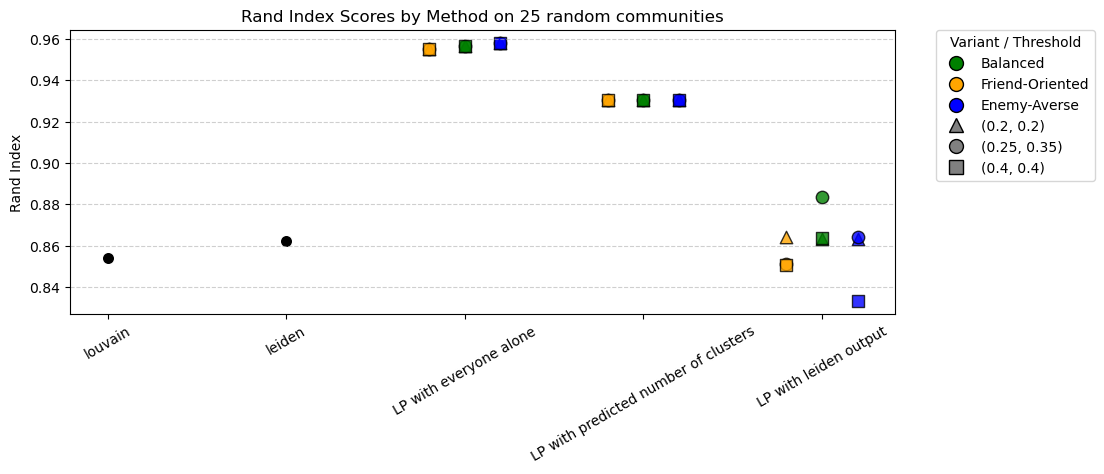

Figure saved as /Users/User/Downloads/local-popular-main-final/community/25 random communities-Modularity.png


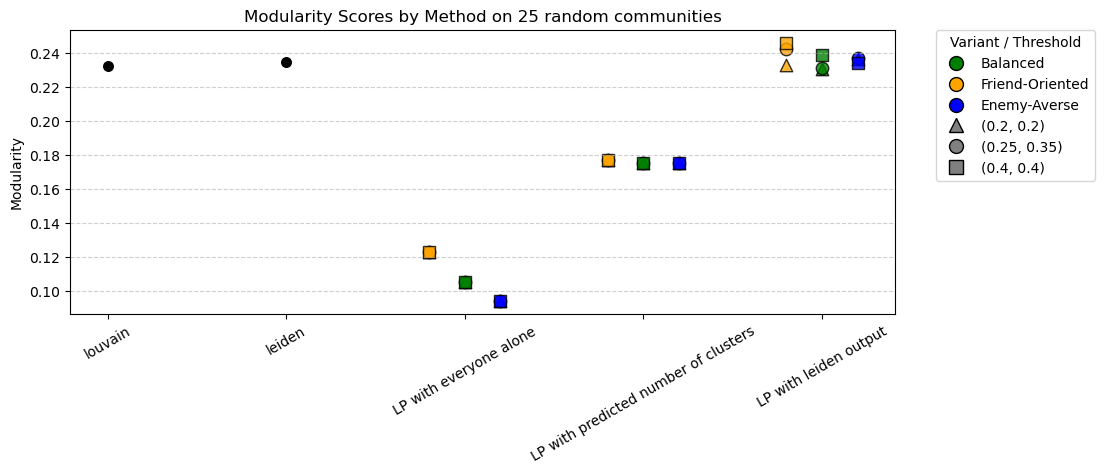

Figure saved as /Users/User/Downloads/local-popular-main-final/community/Cora-Rand Index.png


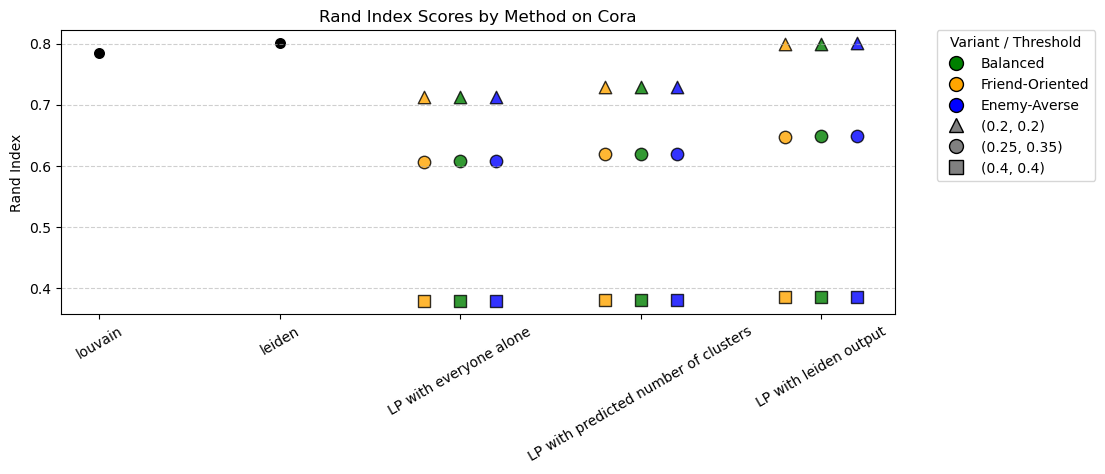

Figure saved as /Users/User/Downloads/local-popular-main-final/community/Cora-Modularity.png


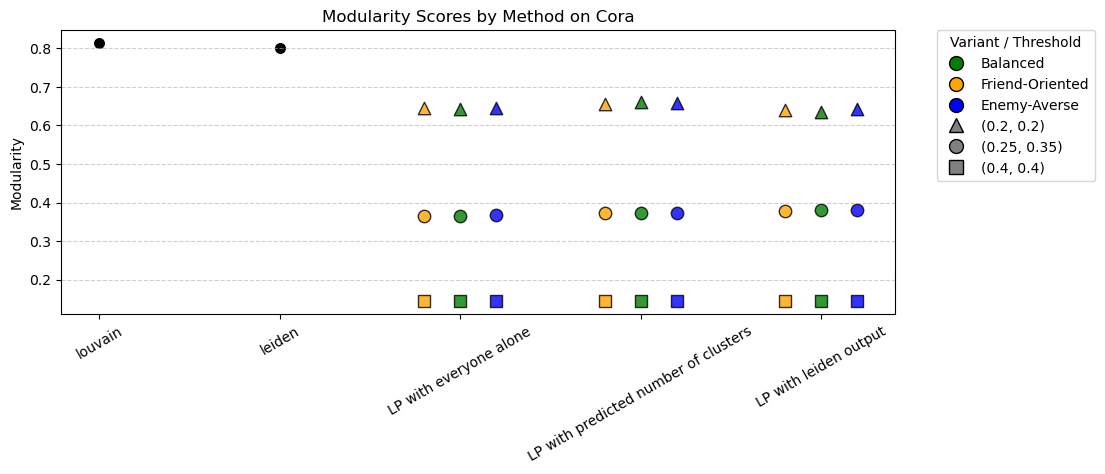

Figure saved as /Users/User/Downloads/local-popular-main-final/community/Jazz-Rand Index.png


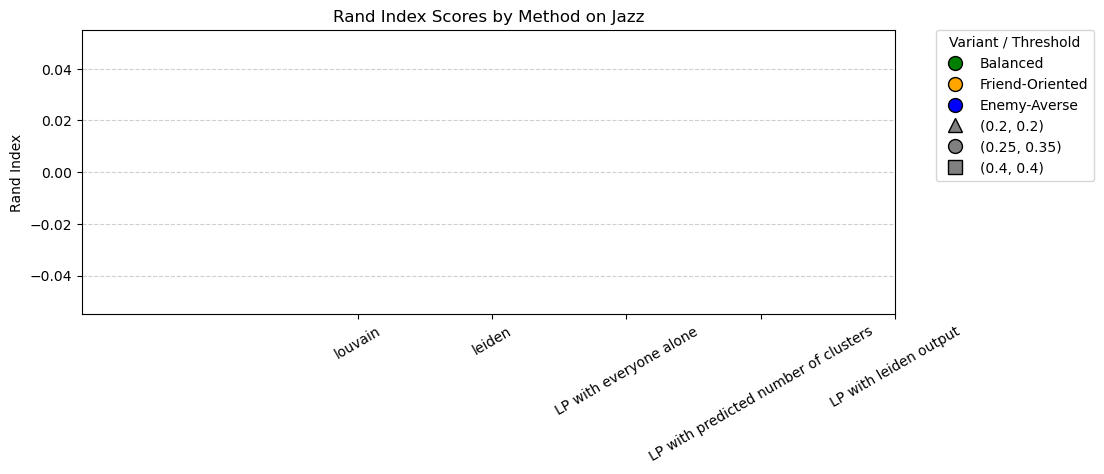

Figure saved as /Users/User/Downloads/local-popular-main-final/community/Jazz-Modularity.png


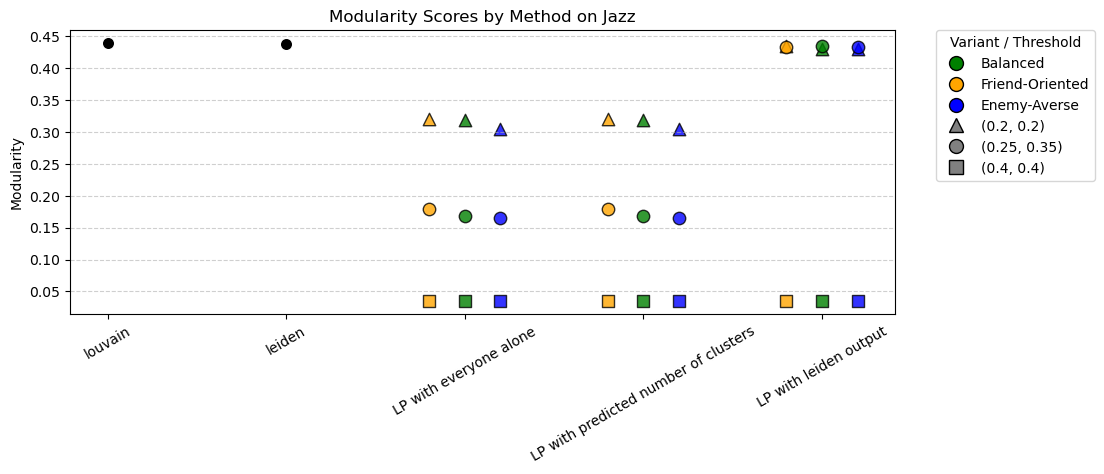

Figure saved as /Users/User/Downloads/local-popular-main-final/community/Karate Club-Rand Index.png


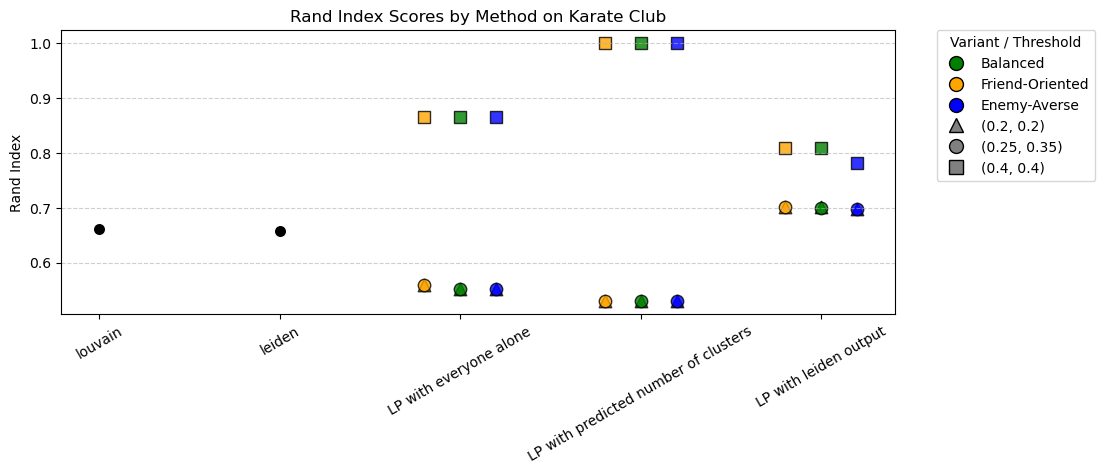

Figure saved as /Users/User/Downloads/local-popular-main-final/community/Karate Club-Modularity.png


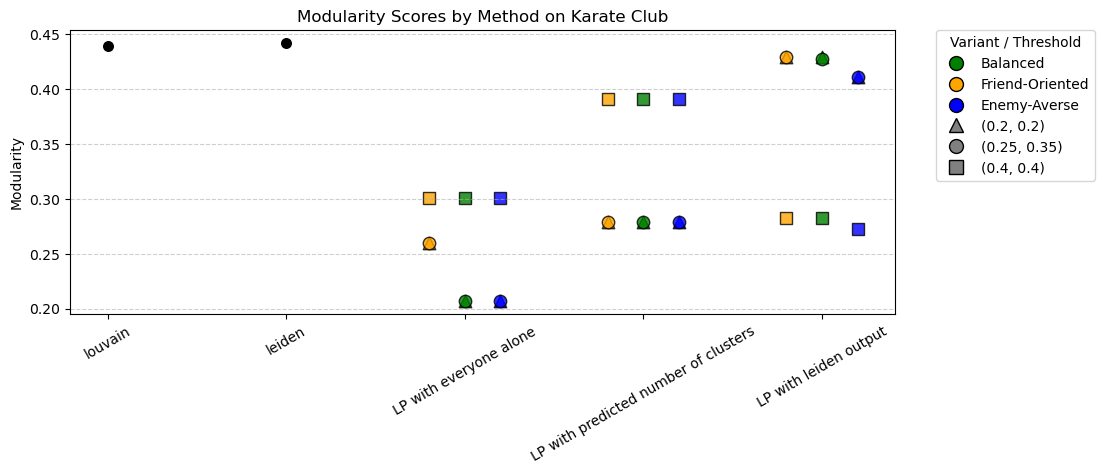

In [109]:
for Dataset in ['25 random communities', 'Cora' ,'Jazz' ,'Karate Club']:
    for score in ['Rand Index', 'Modularity']:
        plot_and_save(dfs,labels, Dataset, score, save_path=f'/Users/User/Downloads/local-popular-main-final/community/{Dataset}-{score}.png')
